# o professor falou que podemos fazer métodos de reconhecimento de poisoning no trabalho!!!
## model backdoor - pode usar watermarks como a solução canário pra ataques de buffer overflow
## buffer overflow - solução "canário" 

## aqui teria que mudar os clientes pra infectar os dados que serão enviados pro servidor e serão usados pra poder treinar o modelo final
#### model biasing - teroicamente basicamente seria flippar os dados de uma cliente e deixar ele com uma grande quantidade de dados
#### model posioning - adicionar ruido em uma ou mais camadas dos modelo - um caso simples de posioning é adicionar no proŕprio cliente antes de mandar os pesos pro servidor, adicionar ruído em algumas camadas. um outro mais complexo é inverter os pesos de uma camada ou mais, pq aqui n muda a media e o desvio dos dados 
#### model gradient inversion - (https://github.com/AllanMSouza/MinicursoSBSeg2025) - usa uma imagem de ruído, passa pelo modelo até os pesos ficarem parecidos com o do modelo original, dai ao inves de atualizar os pesos do modelo fake faz a atualização da imagem de forma que vc vai conseguir recuperar as imagens usadas not treino (!?), fica e loop até diminuir as distÂncias dos epsos do dois modelos ficar baixa


In [7]:
!python -m pip install flwr==1.9.0
!python -m pip install flwr_datasets



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
  Using cached flwr_datasets-0.5.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached datasets-3.1.0-py3-none-any.whl.metadata (20 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached hf_xet-1.1.10-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.7 kB)
Using cached flwr_datasets-0.5.0-py3-none-any.whl (87 kB)
Using cached datasets-3.1.0-py3-none-any.whl (480 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/

In [8]:
from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner, DirichletPartitioner
from flwr_datasets.visualization import plot_label_distributions, plot_comparison_label_distribution

In [9]:
fds_iid = FederatedDataset(
    dataset="cifar10",
    partitioners={"train": IidPartitioner(num_partitions=20)})

partitioner = fds_iid.partitioners["train"]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/120M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/23.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

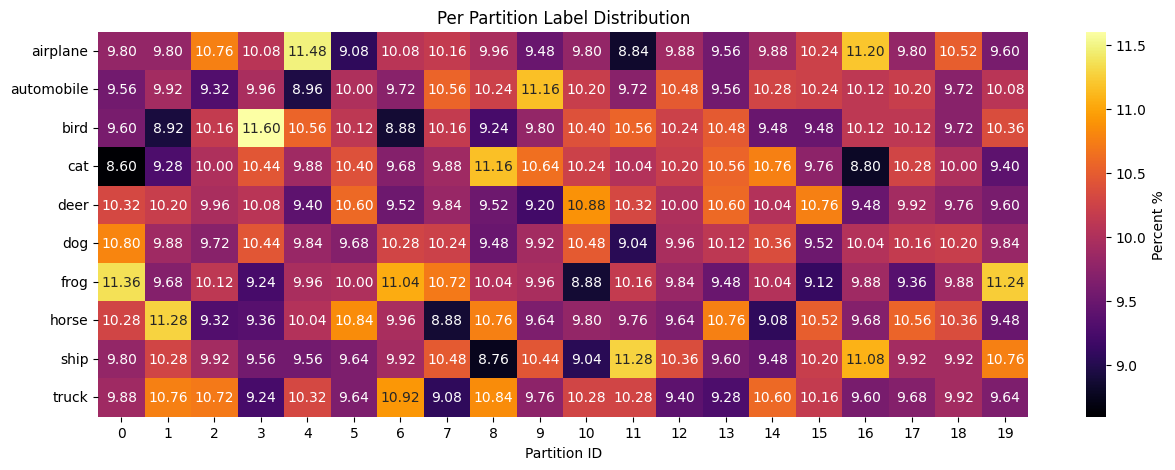

In [10]:
figure, axis, dataframe = plot_label_distributions(
    partitioner=partitioner,
    label_name="label",
    size_unit="percent",
    plot_type="heatmap",
    legend=True,
    cmap='inferno',
    figsize=(15, 5),
    plot_kwargs={"annot": True},
)

In [11]:
fds_niid = FederatedDataset(
    dataset="cifar10",
    partitioners={
        "train": DirichletPartitioner(
            num_partitions=20,
            partition_by="label",
            alpha=0.1,
            min_partition_size=0,
        ),
    },
)

partitioner = fds_niid.partitioners["train"]

In [12]:
partitioner_list = []
alpha_list = [10_000.0, 100.0, 1.0, 0.1, 0.01, 0.00001]
for alpha in alpha_list:
    fds = FederatedDataset(
        dataset="cifar10",
        partitioners={
            "train": DirichletPartitioner(
                num_partitions=20,
                partition_by="label",
                alpha=alpha,
                min_partition_size=0,
            ),
        },
    )
    partitioner_list.append(fds.partitioners["train"])

/home/c-specp25-2/ra290192/Documents/mo809_new/mo809/lab6/mo809/lib64/python3.12/site-packages/flwr_datasets/visualization/comparison_label_distribution.py:222: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


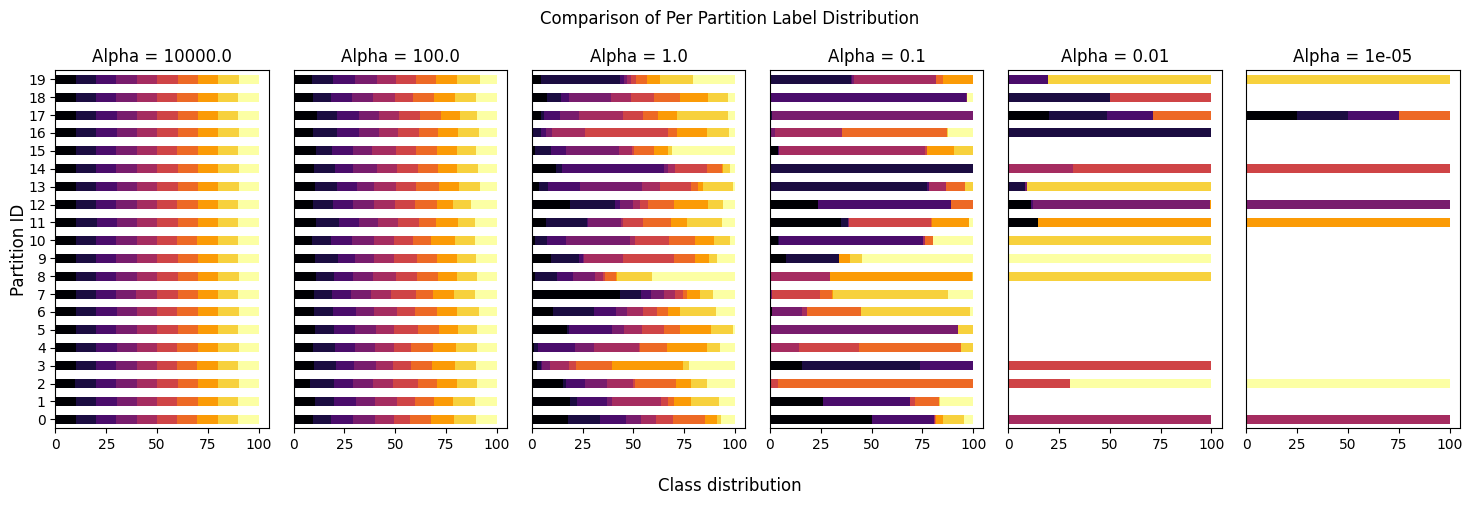

In [13]:
fig, axes, dataframe_list = plot_comparison_label_distribution(
    partitioner_list=partitioner_list,
    label_name="label",
    cmap="inferno",
    figsize=(15, 5),
    titles=[f"Alpha = {alpha}" for alpha in alpha_list],
)

In [15]:
import flwr as fl
class Cliente(fl.client.NumPyClient):
    def __init__(self, cid, niid, num_clients, dirichlet_alpha):
         self.cid             = int(cid)
         self.niid            = niid
         self.num_clients     = num_clients
         self.dirichlet_alpha = dirichlet_alpha

         self.x_train, self.y_train, self.x_test, self.y_test = self.load_data()
         self.model                                           = self.create_model(self.x_train.shape)

2025-09-30 10:18:36.170660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-30 10:18:36.272460: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 10:18:41.510443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ImportError: cannot import name 'runtime_version' from 'google.protobuf' (/home/c-specp25-2/ra290192/Documents/mo809_new/mo809/lab6/mo809/lib64/python3.12/site-packages/google/protobuf/__init__.py)

In [ ]:
def get_parameters(self, config):
    return self.model.get_weights()

In [ ]:
def load_data(self):
    if self.niid:
        partitioner_train = DirichletPartitioner(num_partitions=self.num_clients, partition_by="label",
                                alpha=self.dirichlet_alpha, min_partition_size=0,
                                self_balancing=False)
        partitioner_test = DirichletPartitioner(num_partitions=self.num_clients, partition_by="label",
                                alpha=self.dirichlet_alpha, min_partition_size=0,
                                self_balancing=False)
    else:
        partitioner_train =  IidPartitioner(num_partitions=self.num_clients)
        partitioner_test  = IidPartitioner(num_partitions=self.num_clients)

    fds               = FederatedDataset(dataset='mnist', partitioners={"train": partitioner_train})
    train             = fds.load_partition(self.cid).with_format("numpy")

    fds_eval          = FederatedDataset(dataset='mnist', partitioners={"test": partitioner_test})
    test              = fds_eval.load_partition(self.cid).with_format("numpy")

    return train['image']/255.0, train['label'], test['image']/255.0, test['label']

In [ ]:
def create_model(self, input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16,  activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax'),

    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
def fit(self, parameters, config):
      self.model.set_weights(parameters)

      history = self.model.fit(self.x_train, self.y_train, epochs=1)
      acc     = np.mean(history.history['accuracy'])
      loss    = np.mean(history.history['loss'])

      trained_parameters = self.model.get_weights()

      fit_msg = {
          'cid'     : self.cid,
          'accuracy': acc,
          'loss'    : loss,
      }

      self.log_client('train.csv', config['server_round'], acc, loss)
      return trained_parameters, len(self.x_train), fit_msg

In [ ]:
def evaluate(self, parameters, config):
      self.model.set_weights(parameters)
      loss, acc = self.model.evaluate(self.x_test, self.y_test)
      eval_msg = {
          'cid'     : self.cid,
          'accuracy': acc,
          'loss'    : loss
      }
      self.log_client('evaluate.csv', config['server_round'], acc, loss)
      return loss, len(self.x_test), eval_msg

In [ ]:
def log_client(self, file_name, server_round, acc, loss):
    with open(file_name, 'a') as file:
        file.write(f'{server_round}, {self.cid}, {acc}, {loss}\n')

In [ ]:
class Servidor(fl.server.strategy.FedAvg):
    def __init__(self, num_clients, dirichlet_alpha, fraction_fit=0.2):
        self.num_clients     = num_clients
        self.dirichlet_alpha = dirichlet_alpha

        super().__init__(fraction_fit=fraction_fit min_available_clients=num_clients)

In [ ]:
def configure_fit(self, server_round, parameters, client_manager):
    """Configure the next round of training."""

    config = {
        'server_round': server_round,
    } 
    fit_ins = FitIns(parameters, config)


    sample_size, min_num_clients = self.num_fit_clients(
        client_manager.num_available()
    )
    clients = client_manager.sample(
        num_clients=sample_size, min_num_clients=min_num_clients
    )

    # Return client/config pairs
    print(clients)
    return [(client, fit_ins) for client in clients]

In [ ]:
def aggregate_fit(self, server_round, results, failures):       
    parameters_list = []
    for _, fit_res in results:
        parameters = parameters_to_ndarrays(fit_res.parameters)
        exemplos   = int(fit_res.num_examples)

        parameters_list.append([parameters, exemplos])

    agg_parameters = aggregate(parameters_list)
    agg_parameters = ndarrays_to_parameters(agg_parameters)

    return agg_parameters, {}

In [ ]:
def configure_evaluate(self, server_round, parameters, client_manager):
    config = {
        'server_round': server_round,
    } 

    evaluate_ins = EvaluateIns(parameters, config)


    sample_size, min_num_clients = self.num_evaluation_clients(
        client_manager.num_available()
    )

    clients = client_manager.sample(
        num_clients=sample_size, min_num_clients=min_num_clients
    )

    return [(client, evaluate_ins) for client in clients]

In [ ]:
def aggregate_evaluate(self, server_round, results, failures):
    accuracies = []

    for _, response in results:
        acc = response.metrics['accuracy']
        accuracies.append(acc)

    avg_acc = sum(accuracies)/len(accuracies)
    print(f"Rodada {server_round} acurácia agregada: {avg_acc}")

    return avg_acc, {}